##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 畳み込みニューラルネットワーク (Convolutional Neural Networks)

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     View on TensorFlow.org</a>   </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colabで実行</a>
</td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/images/cnn.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">     View source on GitHub</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Download notebook</a>   </td>
</table>

このチュートリアルでは、MNIST の数の分類をするための、シンプルな[畳み込みニューラルネットワーク](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN: Convolutional Neural Network) の学習について説明します。このシンプルなネットワークは MNIST テストセットにおいて、99%以上の精度を達成します。このチュートリアルでは、[Keras Sequential API](https://www.cs.toronto.edu/~kriz/cifar.html)を使用するため、ほんの数行のコードでモデルの作成と学習を行うことができます。<br>Note: GPU を使うことで CNN をより早く学習させることができます。もし、このノートブックを Colab で実行しているならば、編集 -&gt; ノートブックの設定 -&gt; ハードウェアアクセラレータ -&gt; GPU から無料のGPUを有効にすることができます。


### TensorFlowのインポート

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

### MNISTデータセットのダウンロードと準備

CIFAR10 データセットには、10 のクラスに 60,000 のカラー画像が含まれ、各クラスに 6,000 の画像が含まれています。 データセットは、50,000 のトレーニング画像と 10,000 のテスト画像に分割されています。クラスは相互に排他的であり、それらの間に重複はありません。

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170498071/170498071 [==============================] - 11s 0us/step


### データを確認する

データセットが正しいことを確認するために、トレーニングセットの最初の 25 枚の画像をプロットし、各画像の下にクラス名を表示しましょう。


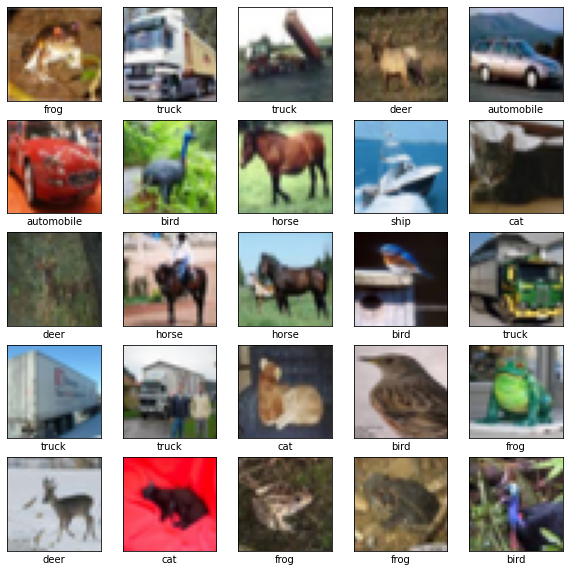

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### 畳み込みの基礎部分の作成

下記の6行のコードは、一般的なパターンで畳み込みの基礎部分を定義しています: [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) と [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) レイヤーのスタック。

入力として、CNNはバッチサイズを無視して、形状（image_height、image_width、color_channels）のテンソルを取ります。これらのディメンションを初めて使用する場合、color_channelsは（R,G,B）を参照します。 この例では、CIFAR　画像の形式である形状（32, 32, 3）の入力を処理するようにCNNを構成します。これを行うには、引数`input_shape`を最初のレイヤーに渡します。


In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

これまでのモデルのアーキテクチャを表示します。

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-traina

上記より、すべての Conv2D と MaxPooling2D レイヤーの出力は shape (height, width, channels) の 3D テンソルであることがわかります。width と height の寸法は、ネットワークが深くなるにつれて縮小する傾向があります。各 Conv2D レイヤーの出力チャネルの数は、第一引数 (例: 32 または 64) によって制御されます。通常、width とheight が縮小すると、各 Conv2D レイヤーにさらに出力チャネルを追加する余裕が (計算上) できます。

### 上に Dense レイヤーを追加

モデルを完成するために、(shape (3, 3, 64) の) 畳み込みの基礎部分からの最後の出力テンソルを、1つ以上の Dense レイヤーに入れて分類を実行します。現在の出力は 3D テンソルですが、Dense レイヤーは入力としてベクトル (1D) を取ります。まず、3D 出力を 1D に平滑化 (または展開) してから、最上部に1つ以上の Dense レイヤーを追加します。MNIST は 10 個の出力クラスを持ちます。そのため、我々は最後の Dense レイヤーの出力を 10 にし、softmax関数を使用します。

In [7]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

モデルの完全なアーキテクチャは次のとおりです。

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

ネットワークの要約は、(4, 4, 64) 出力が、2 つの高密度レイヤーを通過する前に形状のベクトル (1024) に平坦化されたことを示しています。

### モデルのコンパイルと学習

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 70s 25ms/step - loss: 1.5032 - accuracy: 0.4535 - val_loss: 1.2374 - val_accuracy: 0.5540
Epoch 2/10
1563/1563 [==============================] - 41s 26ms/step - loss: 1.1268 - accuracy: 0.6005 - val_loss: 1.0318 - val_accuracy: 0.6321
Epoch 3/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.9723 - accuracy: 0.6579 - val_loss: 0.9399 - val_accuracy: 0.6701
Epoch 4/10
1563/1563 [==============================] - 38s 24ms/step - loss: 0.8721 - accuracy: 0.6938 - val_loss: 0.9048 - val_accuracy: 0.6822
Epoch 5/10
1563/1563 [==============================] - 40s 26ms/step - loss: 0.7993 - accuracy: 0.7214 - val_loss: 0.8781 - val_accuracy: 0.6936
Epoch 6/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.7368 - accuracy: 0.7409 - val_loss: 0.8511 - val_accuracy: 0.7052
Epoch 7/10
1563/1563 [==============================] - 40s 26ms/step - loss: 0.6904 - accuracy: 0.7589 - val_loss: 0.8787 -

### モデルの評価

313/313 - 4s - loss: 0.8880 - accuracy: 0.7084 - 4s/epoch - 12ms/step


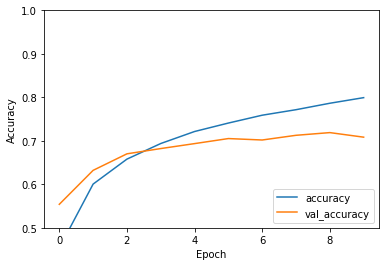

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [11]:
print(test_acc)

0.7084000110626221


この単純な CNN は、 数行のコードで 70％ を超えるテスト精度を達成しています。別の CNN スタイルについては、Keras サブクラス化 API と{`tf.GradientTape`を使用する[ 上級者向け TensorFlow 2 クイックスタート](https://www.tensorflow.org/tutorials/quickstart/advanced)の例を参照してください。